Title
-----

This is a test

In [1]:
import sys
print(sys.version)

3.11.10 | packaged by conda-forge | (main, Oct 16 2024, 01:17:14) [MSC v.1941 64 bit (AMD64)]


In [2]:
import os
import numpy as np
from quickBayes.workflow.model_selection.QlData import QLData
from quickBayes.functions.qldata_function import QlDataFunction
from quickBayes.utils.spline import spline
from quickBayes.utils.general import get_background_function
from quickBayes.workflow.model_selection.template import ModelSelectionWorkflow
from quickBayes.functions.base import BaseFitFunction
from quickBayes.utils.crop_data import crop


In [3]:
DATA_DIR = os.path.join('..', '..', '..', 'test', 'data')

sample_file = os.path.join(DATA_DIR, 'sample_data_red.npy')
resolution_file = os.path.join(DATA_DIR, 'resolution_data_red.npy')

sx, sy, se = np.load(sample_file)
rx, ry, re = np.load(resolution_file)

resolution = {'x': rx, 'y': ry}

In [4]:
results = {}
results_errors = {}
start_x = -0.4
end_x = 0.4
max_peaks = 3

In [5]:
workflow = QLData(results, results_errors)
new_x, ry = workflow.preprocess_data(sx, sy, se, start_x, end_x, resolution)

In [6]:
elastic = True

In [7]:
BG = get_background_function('linear')
function = QlDataFunction(BG, elastic, new_x, ry, start_x, end_x)

In [8]:
lower, upper = function.get_bounds()
guess = function.get_guess()
lower, upper = function.get_bounds()
workflow.set_scipy_engine(guess, lower, upper)

[0.0, 0.0, 1.0, 0.0]
[-1.0, -1.0, 0.0, -1]
[1.0, 1.0, inf, 1.0]


In [9]:
function_out = workflow.execute(max_peaks, function, guess)

In [10]:
results, results_errors = workflow.get_parameters_and_errors
for key in results.keys():
    if 'log' in key:
        print(key, results[key])

N1:loglikelihood [-659.4019084423829]
N2:loglikelihood [-349.1659820061366]
N3:loglikelihood [-350.87145866741605]


In [11]:
fit_engine = workflow.fit_engine
x_data, y_data, e_data, df, de = fit_engine.get_fit_values(1)

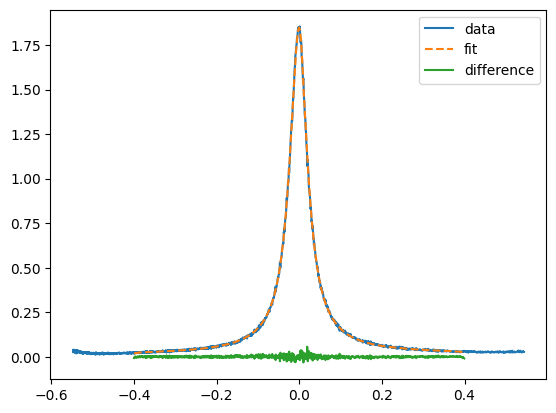

In [17]:
import matplotlib.pyplot as plt

plt.plot(sx, sy, label='data')
plt.plot(x_data, y_data, label='fit', linestyle='--')
plt.plot(x_data, df, label='difference')
plt.legend()
plt.show()

In [18]:
for key in results.keys():
    if 'N2' in key and 'log' not in key:
        print(key, results[key], results_errors[key])

N2:f1.BG gradient [0.006659735795310354] [0.0003068745966659226]
N2:f1.BG constant [0.013764481874438657] [0.0002736238921217582]
N2:f2.f1.Amplitude [0.005037941717230454] [0.0003451323760671165]
N2:f2.f1.Centre [-0.0006646277296653441] [3.708772763365955e-05]
N2:f2.f2.Amplitude [0.02722853361627412] [0.0012762619531348396]
N2:f2.f2.Peak Centre [-0.0006646277296653441] [3.708772763365955e-05]
N2:f2.f2.Gamma [0.1955402890215823] [0.010250383280798286]
N2:f2.f3.Amplitude [0.13233755828135557] [0.001280142691823196]
N2:f2.f3.Peak Centre [-0.0006646277296653441] [3.708772763365955e-05]
N2:f2.f3.Gamma [0.04386076730134469] [0.0005897110705109352]
N2:f2.f2.EISF [0.15613548319605894] [0.024220748990546558]
N2:f2.f3.EISF [0.03667278166254032] [0.010936770105687544]
